In [1]:
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 1
%aimport visualization.vis
%aimport utils.utils

In [ ]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd

from torch_geometric.loader import DataLoader
from argparse import ArgumentParser
from datasets import ArgoverseV2Dataset
from predictors import QCNet
from predictors.autoval import AntoQCNet
from transforms import TargetBuilder
from av2.datasets.motion_forecasting import scenario_serialization
from av2.datasets.motion_forecasting.data_schema import (
    ArgoverseScenario,
    ObjectType,
    TrackCategory,
)
from av2.map.map_api import ArgoverseStaticMap
from pathlib import Path
from visualization.vis import plot_traj_with_data, plot_traj, generate_video
from utils.utils import get_transform_mat, get_auto_pred, add_new_agent, reward_function

pl.seed_everything(2023, workers=True)

parser = ArgumentParser()
parser.add_argument("--model", type=str, default="QCNet")
parser.add_argument("--root", type=str, default="~/Multi-agent-competitive-environment/datasets")
parser.add_argument("--batch_size", type=int, default=1)
parser.add_argument("--num_workers", type=int, default=8)
parser.add_argument("--pin_memory", type=bool, default=True)
parser.add_argument("--persistent_workers", type=bool, default=True)
parser.add_argument("--accelerator", type=str, default="auto")
parser.add_argument("--devices", type=int, default=1)
parser.add_argument("--ckpt_path", default="~/Multi-agent-competitive-environment/checkpoints/epoch=10-step=274879.ckpt", type=str)
args = parser.parse_args("")

model = {
    "QCNet": AntoQCNet,
}[args.model].load_from_checkpoint(checkpoint_path=args.ckpt_path)
val_dataset = {
    "argoverse_v2": ArgoverseV2Dataset,
}[model.dataset](
    root=args.root,
    split="val",
    transform=TargetBuilder(model.num_historical_steps, model.num_future_steps),
)


Global seed set to 2023
/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/pytorch_lightning/utilities/migration/utils.py:51: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.1, which is newer than your current Lightning version: v2.0.4
  rank_zero_warn(


In [3]:
dataloader = DataLoader(
    # val_dataset[[val_dataset.raw_file_names.index('161c1772-7d8f-4ab4-a1bd-9259cfff7a58')]],
    # val_dataset[[val_dataset.raw_file_names.index('0a8dd03b-02cf-4d7b-ae7f-c9e65ad3c900')]],
    # val_dataset[[val_dataset.raw_file_names.index('0a09b183-3553-4c85-9a12-976409e4aeab')]],
    # val_dataset[[val_dataset.raw_file_names.index('00a9541f-a00c-45c6-9071-dec34f5f818b')]],
    # val_dataset[[val_dataset.raw_file_names.index('dc926add-2192-4894-b6a1-3693008c4ff0')]],
    # val_dataset[[val_dataset.raw_file_names.index('68079785-1be2-4935-b29b-488b222dfa6f')]],
    val_dataset[[val_dataset.processed_file_names.index('236df665-eec6-4c25-8822-950a6150eade'+'.pkl')]],
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=args.pin_memory,
    persistent_workers=args.persistent_workers,
)

trainer = pl.Trainer(accelerator=args.accelerator, devices=args.devices)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


/home/guanren/anaconda3/envs/QCNet/lib/python3.8/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


/home/guanren/Multi-agent-competitive-environment/datasets/val/raw/236df665-eec6-4c25-8822-950a6150eade/scenario_236df665-eec6-4c25-8822-950a6150eade.parquet


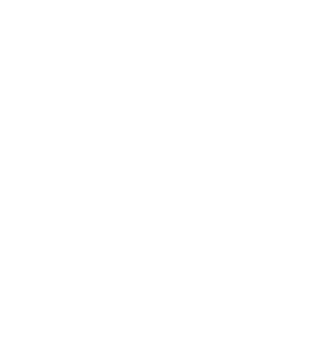

In [4]:
it = iter(dataloader)
import numpy as np
from shapely.geometry import Polygon,Point
    
data = next(it, None)
# print(val_dataset.raw_file_names[1007])
scenario_id = data['scenario_id'][0]
argoverse_scenario_dir = Path("~/Multi-agent-competitive-environment/datasets/val/raw")

all_scenario_files = sorted(argoverse_scenario_dir.rglob(f"*_{scenario_id}.parquet"))
scenario_file_list = list(all_scenario_files)
scenario_path = scenario_file_list[0]
print(scenario_path)

static_map_path = scenario_path.parents[0] / f"log_map_archive_{scenario_id}.json"

scenario = scenario_serialization.load_argoverse_scenario_parquet(scenario_path)
scenario_static_map = ArgoverseStaticMap.from_json(static_map_path)

plot_traj_with_data(data,scenario_static_map,5,4,t=50)

In [30]:

for param in model.encoder.parameters():
        param.requires_grad = False
for param in model.decoder.parameters():
        param.requires_grad = False
agent_index = torch.nonzero(data["agent"]["category"] == 3, as_tuple=False).item()
# print(data['agent']['num_nodes'])
# df2 = pd.read_parquet('/home/guanren/MARL_AD_CCE/argoverse2_pred/00a50e9f-63a1-4678-a4fe-c6109721ecbadistance_limit5.0_penalty_initial_value1.0_seed1/scenario_00a50e9f-63a1-4678-a4fe-c6109721ecba_2024_06_10_15_20_58.parquet')
# df2.hist(column = ['position_x', 'position_y'], density=True)

In [28]:
vid_path = "rebuttal1.webm"
generate_video(new_input_data,scenario_static_map, model, vid_path)

tensor([[2.6431, 2.7418, 2.7189, 2.7859, 2.7813, 2.8163]], device='cuda:0')
tensor([[4.6202, 4.6732, 4.6629, 4.7338, 4.7205, 4.7706]], device='cuda:0')
tensor([[6.0511, 6.1453, 6.0899, 6.1512, 6.1657, 6.1823]], device='cuda:0')
tensor([[7.0363, 7.1398, 7.1062, 7.1811, 7.1480, 7.1566]], device='cuda:0')
tensor([[7.7139, 7.7942, 7.7731, 7.8121, 7.8085, 7.8249]], device='cuda:0')
tensor([[7.8670, 7.9966, 7.9738, 8.0543, 8.0521, 8.0442]], device='cuda:0')
tensor([[7.8481, 7.8700, 7.8582, 7.9198, 7.8942, 7.9314]], device='cuda:0')
tensor([[7.8531, 7.8670, 7.8665, 7.8751, 7.8712, 7.8913]], device='cuda:0')
tensor([[7.8314, 7.8495, 7.8409, 7.8469, 7.8541, 7.8629]], device='cuda:0')
tensor([[7.8338, 7.8426, 7.8402, 7.8373, 7.8427, 7.8528]], device='cuda:0')
tensor([[7.8326, 7.8417, 7.8369, 7.8421, 7.8391, 7.8381]], device='cuda:0')
tensor([[7.8325, 7.8385, 7.8368, 7.8268, 7.8358, 7.8408]], device='cuda:0')


OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


In [ ]:
[x.value for x in _STATIC_OBJECT_TYPES]

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.stats import entropy, wasserstein_distance
from concurrent.futures import ProcessPoolExecutor
import matplotlib.pyplot as plt

def cal_Hellinger_dis(P, Q):
    """
    Calculate the Hellinger distance for two distribution
    """
    # Convert into probability first
    P = P/np.sum(P)
    Q = Q/np.sum(Q)

    H_dist = (1 / np.sqrt(2)) * np.linalg.norm(np.abs(np.sqrt(P) - np.sqrt(Q)))
    return H_dist


def cal_KL_div(P, Q):
    """
    Calculate the KL-divergence for two distribution
    sum(P(x) * log (P(x)/Q(x)))
    """
    # Convert into probability first
    P = P+1e-7
    Q = Q+1e-7
    P = P/np.sum(P)
    Q = Q/np.sum(Q)

    KL_div = entropy(pk=P, qk=Q, base=None, axis=0)
    return KL_div

def cal_wasserstein_distance(P, Q):
    P = P/np.sum(P)
    Q = Q/np.sum(Q)
    return wasserstein_distance(P, Q)

def filter_data(df):
    df = df[(df['position_x'] != 0) | (df['position_y'] != 0) ]
    return df

def read_parquet_file(base_dir, file):
    df = pd.read_parquet(os.path.join(base_dir, file, f'scenario_{file}.parquet'))
    return df

def read_parquet_file_trafficgamer(base_dir, file, idx, length):
    df = pd.read_parquet(os.path.join(base_dir, f'scenario{idx+1}', f'{file}_trafficgamer', f'scenario_{file}.parquet'))
    return df[:length]

def read_parquet_file_gameformer(base_dir, file, idx, length):
    df = pd.read_parquet(os.path.join(base_dir, f'scenario{idx+1}', f'{file}_gameformer_baseline', f'scenario_{file}.parquet'))
    return df[:length]

def read_parquet_file_qcnet(base_dir, file, idx, length):
    df = pd.read_parquet(os.path.join(base_dir, f'scenario{idx+1}', f'{file}_qcnet_baseline', f'scenario_{file}.parquet'))
    return df[:length]

def read_parquet_file_mappo(base_dir, file, idx, length):
    df = pd.read_parquet(os.path.join(base_dir, f'scenario{idx+1}', f'{file}_MAPPO', f'scenario_{file}.parquet'))
    return df[:length]

file_list = ['d1f6b01e-3b4a-4790-88ed-6d85fb1c0b84', '00a50e9f-63a1-4678-a4fe-c6109721ecba', 
             '236df665-eec6-4c25-8822-950a6150eade', 'cb0133ff-f7ad-43b7-b260-7068ace15307', 
             'cdf70cc8-d13d-470b-bb39-4f1812acc146', '3856ed37-4a05-4131-9b12-c4f4716fec92']

argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")
trafficgamer_dir = Path("./argoverse2_pred")

with ProcessPoolExecutor() as executor:
    df_list = list(executor.map(read_parquet_file, [argoverse_scenario_dir] * len(file_list), file_list))
    lengths = [len(df) for df in df_list]
    df2_list = [read_parquet_file_trafficgamer(trafficgamer_dir, file, idx, length) for idx, (file, length) in enumerate(zip(file_list, lengths))]
    df2_list = [filter_data(df) for df in df2_list]
    df3_list = [read_parquet_file_mappo(trafficgamer_dir, file, idx, length) for idx, (file, length) in enumerate(zip(file_list, lengths))]
    df3_list = [filter_data(df) for df in df3_list]
    df4_list = [read_parquet_file_qcnet(trafficgamer_dir, file, idx, length) for idx, (file, length) in enumerate(zip(file_list, lengths))]
    df4_list = [filter_data(df) for df in df4_list]
    df5_list = [read_parquet_file_gameformer(trafficgamer_dir, file, idx, length) for idx, (file, length) in enumerate(zip(file_list, lengths))]
    df5_list = [filter_data(df) for df in df5_list]

# file_list = [ 'd1f6b01e-3b4a-4790-88ed-6d85fb1c0b84', 
#              'cdf70cc8-d13d-470b-bb39-4f1812acc146', '3856ed37-4a05-4131-9b12-c4f4716fec92',
# ]

# argoverse_scenario_dir = Path("/home/guanren/Multi-agent-competitive-environment/datasets/val/raw")
# trafficgamer_dir = Path("./argoverse2_pred")

# indices = [1,5,6]  # Custom indices

# with ProcessPoolExecutor() as executor:
#     df_list = list(executor.map(read_parquet_file, [argoverse_scenario_dir] * len(file_list), file_list))
#     lengths = [len(df) for df in df_list]
    
#     df2_list = [
#         read_parquet_file_trafficgamer(trafficgamer_dir, file, idx, length)
#         for idx, (file, length) in zip(indices, zip(file_list, lengths))
#     ]
#     df2_list = [filter_data(df) for df in df2_list]
    
#     df3_list = [
#         read_parquet_file_mappo(trafficgamer_dir, file, idx, length)
#         for idx, (file, length) in zip(indices, zip(file_list, lengths))
#     ]
#     df3_list = [filter_data(df) for df in df3_list]
    
#     df4_list = [
#         read_parquet_file_qcnet(trafficgamer_dir, file, idx, length)
#         for idx, (file, length) in zip(indices, zip(file_list, lengths))
#     ]
#     df4_list = [filter_data(df) for df in df4_list]
    
#     df5_list = [
#         read_parquet_file_gameformer(trafficgamer_dir, file, idx, length)
#         for idx, (file, length) in zip(indices, zip(file_list, lengths))
#     ]
#     df5_list = [filter_data(df) for df in df5_list]


df = pd.concat(df_list, ignore_index=True)
df2 = pd.concat(df2_list, ignore_index=True)
df3 = pd.concat(df3_list, ignore_index=True)
df4 = pd.concat(df4_list, ignore_index=True)
df5 = pd.concat(df5_list, ignore_index=True)

# def compute_distances(df):
#     distances = []
#     timesteps = df['timestep'].unique()
    
#     for timestep in timesteps:
#         current_positions = df[df['timestep'] == timestep][['position_x', 'position_y']].values
#         dist_matrix = np.sqrt(np.sum((current_positions[:, np.newaxis, :] - current_positions[np.newaxis, :, :]) ** 2, axis=-1))
#         valid_distances = dist_matrix[(dist_matrix <= 60) & (dist_matrix >= 0.2)]
#         distances.extend(valid_distances)
    
#     return np.array(distances)

# distances = compute_distances(df)
# distances2 = compute_distances(df2)
# distances3 = compute_distances(df3)
# distances4 = compute_distances(df4)
# distances5 = compute_distances(df5)

# distances_df = pd.DataFrame(distances, columns=['distance'])
# distances_df2 = pd.DataFrame(distances2, columns=['distance'])
# distances_df3 = pd.DataFrame(distances3, columns=['distance'])
# distances_df4 = pd.DataFrame(distances4, columns=['distance'])
# distances_df5 = pd.DataFrame(distances5, columns=['distance'])

fig, axes = plt.subplots(1, 4, figsize=(66, 12))


bins = np.linspace(0, 15.2, 100)

# gt_prob_density, gt_bins, _ = axes[0].hist(distances_df['distance'], bins, density=True, alpha=0.5,edgecolor='k', color='blue', label='Ground-Truth')
# trafficgamer_prob_density, trafficgamer_bins, _ = axes[0].hist(distances_df2['distance'], bins, density=True, edgecolor='k',alpha=0.5, color='orange', label='TrafficGamer')

# gt_prob_density, gt_bins, _ = axes[1].hist(distances_df['distance'], bins, density=True, alpha=0.5, edgecolor='k',color='blue', label='Ground-Truth')
# MAPPO_prob_density, MAPPO_bins, _ = axes[1].hist(distances_df3['distance'], bins, density=True, alpha=0.5, edgecolor='k',color='green', label='MAPPO')

# gt_prob_density, gt_bins, _ = axes[2].hist(distances_df['distance'], bins, density=True, alpha=0.5, edgecolor='k',color='blue', label='Ground-Truth')
# QCNet_prob_density, QCNet_bins, _ = axes[2].hist(distances_df4['distance'], bins, density=True, alpha=0.5, edgecolor='k',color='brown', label='QCNet')

# gt_prob_density, gt_bins, _ = axes[3].hist(distances_df['distance'], bins, density=True, alpha=0.5, edgecolor='k',color='blue', label='Ground-Truth')
# GameFormer_prob_density, GameFormer_bins, _ = axes[3].hist(distances_df5['distance'], bins, density=True, alpha=0.5, edgecolor='k',color='purple', label='GameFormer')

# kl_divergence = cal_KL_div(gt_prob_density, trafficgamer_prob_density)
# hellinger_dist = cal_Hellinger_dis(gt_prob_density, trafficgamer_prob_density)
# wasserstein_dist = cal_wasserstein_distance(gt_prob_density, trafficgamer_prob_density)

# axes[0].text(0, 0.20, f'$D_H: {hellinger_dist:.4f}$', size=48)
# axes[0].text(0, 0.15, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
# axes[0].text(0, 0.10, f'$D_W: {wasserstein_dist:.4f}$', size=48)

# kl_divergence = cal_KL_div(gt_prob_density, MAPPO_prob_density)
# hellinger_dist = cal_Hellinger_dis(gt_prob_density, MAPPO_prob_density)
# wasserstein_dist = cal_wasserstein_distance(gt_prob_density, MAPPO_prob_density)

# axes[1].text(0, 0.20, f'$D_H: {hellinger_dist:.4f}$', size=48)
# axes[1].text(0, 0.15, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
# axes[1].text(0, 0.10, f'$D_W: {wasserstein_dist:.4f}$', size=48)

# kl_divergence = cal_KL_div(gt_prob_density, QCNet_prob_density)
# hellinger_dist = cal_Hellinger_dis(gt_prob_density, QCNet_prob_density)
# wasserstein_dist = cal_wasserstein_distance(gt_prob_density, QCNet_prob_density)

# axes[2].text(0, 0.20, f'$D_H: {hellinger_dist:.4f}$', size=48)
# axes[2].text(0, 0.15, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
# axes[2].text(0, 0.10, f'$D_W: {wasserstein_dist:.4f}$', size=48)

# kl_divergence = cal_KL_div(gt_prob_density, GameFormer_prob_density)
# hellinger_dist = cal_Hellinger_dis(gt_prob_density, GameFormer_prob_density)
# wasserstein_dist = cal_wasserstein_distance(gt_prob_density, GameFormer_prob_density)

# axes[3].text(0, 0.2, f'$D_H: {hellinger_dist:.4f}$', size=48)
# axes[3].text(0, 0.15, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
# axes[3].text(0, 0.10, f'$D_W: {wasserstein_dist:.4f}$', size=48)

# axes[0].legend(fontsize=36)
# axes[1].legend(fontsize=36)
# axes[2].legend(fontsize=36)
# axes[3].legend(fontsize=36)

# for ax in axes:
#     ax.tick_params(axis='both', labelsize=36)

# fig.suptitle('Vehicle Distance Distribution (cross road)', fontsize=60)
# axes[0].set_ylabel('Probability Density', fontsize=48)
# fig.supxlabel('Distance (m)', fontsize=48)
# plt.tight_layout(rect=[0, 0, 0, 0.85])
# plt.show()

df['speed'] = np.sqrt(df['velocity_x']**2 + df['velocity_y']**2)
df2['speed'] = np.sqrt(df2['velocity_x']**2 + df2['velocity_y']**2)
df3['speed'] = np.sqrt(df3['velocity_x']**2 + df3['velocity_y']**2)
df4['speed'] = np.sqrt(df4['velocity_x']**2 + df4['velocity_y']**2)
df5['speed'] = np.sqrt(df5['velocity_x']**2 + df5['velocity_y']**2)

df = df.loc[df['speed'] > 0.3]
df2 = df2.loc[df2['speed'] > 0.3]
df3 = df3.loc[df3['speed'] > 0.3]
df4 = df4.loc[df4['speed'] > 0.3]
df5 = df5.loc[df5['speed'] > 0.3]

gt_prob_density, gt_bins, _ = axes[0].hist(df['speed'], bins, density=True, alpha=0.5,edgecolor='k', color='blue', label='Ground-Truth')
trafficgamer_prob_density, trafficgamer_bins, _ = axes[0].hist(df2['speed'], bins, density=True, edgecolor='k',alpha=0.5, color='orange', label='TrafficGamer')

gt_prob_density, gt_bins, _ = axes[1].hist(df['speed'], bins, density=True, alpha=0.5, edgecolor='k',color='blue', label='Ground-Truth')
MAPPO_prob_density, MAPPO_bins, _ = axes[1].hist(df3['speed'], bins, density=True, alpha=0.5, edgecolor='k',color='green', label='MAPPO')

gt_prob_density, gt_bins, _ = axes[2].hist(df['speed'], bins, density=True, alpha=0.5, edgecolor='k',color='blue', label='Ground-Truth')
QCNet_prob_density, QCNet_bins, _ = axes[2].hist(df4['speed'], bins, density=True, alpha=0.5, edgecolor='k',color='brown', label='QCNet')

gt_prob_density, gt_bins, _ = axes[3].hist(df['speed'], bins, density=True, alpha=0.5, edgecolor='k',color='blue', label='Ground-Truth')
GameFormer_prob_density, GameFormer_bins, _ = axes[3].hist(df5['speed'], bins, density=True, alpha=0.5, edgecolor='k',color='purple', label='GameFormer')

kl_divergence = cal_KL_div(gt_prob_density, trafficgamer_prob_density)
hellinger_dist = cal_Hellinger_dis(gt_prob_density, trafficgamer_prob_density)
wasserstein_dist = cal_wasserstein_distance(gt_prob_density, trafficgamer_prob_density)

axes[0].text(10, 0.20, f'$D_H: {hellinger_dist:.4f}$', size=48)
axes[0].text(10, 0.16, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
axes[0].text(10, 0.12, f'$D_W: {wasserstein_dist:.4f}$', size=48)

kl_divergence = cal_KL_div(gt_prob_density, MAPPO_prob_density)
hellinger_dist = cal_Hellinger_dis(gt_prob_density, MAPPO_prob_density)
wasserstein_dist = cal_wasserstein_distance(gt_prob_density, MAPPO_prob_density)

axes[1].text(10, 0.25, f'$D_H: {hellinger_dist:.4f}$', size=48)
axes[1].text(10, 0.20, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
axes[1].text(10, 0.15, f'$D_W: {wasserstein_dist:.4f}$', size=48)

kl_divergence = cal_KL_div(gt_prob_density, QCNet_prob_density)
hellinger_dist = cal_Hellinger_dis(gt_prob_density, QCNet_prob_density)
wasserstein_dist = cal_wasserstein_distance(gt_prob_density, QCNet_prob_density)

axes[2].text(10, 0.16, f'$D_H: {hellinger_dist:.4f}$', size=48)
axes[2].text(10, 0.12, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
axes[2].text(10, 0.08, f'$D_W: {wasserstein_dist:.4f}$', size=48)

kl_divergence = cal_KL_div(gt_prob_density, GameFormer_prob_density)
hellinger_dist = cal_Hellinger_dis(gt_prob_density, GameFormer_prob_density)
wasserstein_dist = cal_wasserstein_distance(gt_prob_density, GameFormer_prob_density)

axes[3].text(10, 0.5, f'$D_H: {hellinger_dist:.4f}$', size=48)
axes[3].text(10, 0.4, f'$D_{{KL}}: {kl_divergence:.4f}$', size=48)
axes[3].text(10, 0.3, f'$D_W: {wasserstein_dist:.4f}$', size=48)

axes[0].legend(fontsize=36, loc='upper right')
axes[1].legend(fontsize=36, loc='upper right')
axes[2].legend(fontsize=36, loc='upper right')
axes[3].legend(fontsize=36, loc='upper right')

for ax in axes:
    ax.tick_params(axis='both', labelsize=36)

fig.suptitle('Vehicle Speed Distribution (all scenarios)', fontsize=60)
axes[0].set_ylabel('Probability Density', fontsize=48)
fig.supxlabel('Speed (m/s)', fontsize=48)
plt.tight_layout(rect=[0, 0, 0, 0.85])
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

scenario_id = 4
file_names = [[f'./cce-gap/qcnet_baseline_rewards_scenario{scenario_id}_seed123.csv', f'./cce-gap/qcnet_baseline_rewards_scenario{scenario_id}_seed321.csv', f'./cce-gap/qcnet_baseline_rewards_scenario{scenario_id}_seed666.csv'],
              [f'./cce-gap/gameformer_baseline_rewards_scenario{scenario_id}_seed123.csv', f'./cce-gap/gameformer_baseline_rewards_scenario{scenario_id}_seed321.csv', f'./cce-gap/gameformer_baseline_rewards_scenario{scenario_id}_seed666.csv'],
              [f'./cce-gap/scenario{scenario_id}_mappo-seed123.csv', f'./cce-gap/scenario{scenario_id}_mappo-seed321.csv', f'./cce-gap/scenario{scenario_id}_mappo-seed666.csv'],
              [f'./cce-gap/scenario{scenario_id}_trafficgamer-seed123.csv', f'./cce-gap/scenario{scenario_id}_trafficgamer-seed321.csv', f'./cce-gap/scenario{scenario_id}_trafficgamer-seed666.csv']
              ]
expert_file = f'./cce-gap/scenario{scenario_id}_expert.csv'
colors = ['blue','brown','purple','orange']
labels = ['QCNet','GameFormer','MAPPO','TrafficGamer']
window_size = 30
agent_number = 5
fig, axs = plt.subplots(1, agent_number, figsize=(66, 12), sharex=True, sharey=False)

for j in range(4):
    for i in range(agent_number):
        merged_data = []
        for file_name in file_names[j]:
            df = pd.read_csv(file_name, usecols=[i])
            raw = df.iloc[:, 0].tolist()
            merged_data.append(raw)
        expert_df = pd.read_csv(expert_file, usecols=[i])
        expert_raw = expert_df.iloc[:, 0].tolist()
        mean_data = np.mean(merged_data, axis=0)
        
        adjusted_data = [float(expert_raw[x]) - mean_data[x] for x in range(300)]
        
        series = pd.Series(adjusted_data)
        rolling_mean = series.rolling(window=window_size, min_periods=1).mean()
        rolling_std = series.rolling(window=window_size, min_periods=1).std()
        
        axs[i].plot(rolling_mean, label=f'{labels[j]}', color=colors[j], linewidth=3)
        axs[i].fill_between(series.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color=colors[j], alpha=0.2)
        print(rolling_mean.iloc[-1])
        print(rolling_std.iloc[-1])

for ax in axs:
    ax.legend(fontsize=36, loc='upper right')
    ax.tick_params(axis='both', labelsize=36)

fig.suptitle(f'Scenario {scenario_id}', fontsize=60)
fig.supxlabel('Episode', fontsize=48)
fig.supylabel('CCE-gap', fontsize=48)
plt.subplots_adjust(left=0.05, right=1, top=0.85, bottom=0.15,
                    wspace=0.21, hspace=0)
plt.xlim(0, 299)
plt.ylim(bottom=0)
plt.xticks(np.arange(0, 300, step=50))
plt.savefig(f"./cce-gap/scenario{scenario_id}_cce-gap.png")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

scenario_id = 4
file_names = [[f'./cce-gap/qcnet_baseline_rewards_scenario{scenario_id}_seed123.csv', f'./cce-gap/qcnet_baseline_rewards_scenario{scenario_id}_seed321.csv', f'./cce-gap/qcnet_baseline_rewards_scenario{scenario_id}_seed666.csv'],
              [f'./cce-gap/gameformer_baseline_rewards_scenario{scenario_id}_seed123.csv', f'./cce-gap/gameformer_baseline_rewards_scenario{scenario_id}_seed321.csv', f'./cce-gap/gameformer_baseline_rewards_scenario{scenario_id}_seed666.csv'],
              [f'./cce-gap/scenario{scenario_id}_mappo2-seed123.csv', f'./cce-gap/scenario{scenario_id}_mappo2-seed321.csv', f'./cce-gap/scenario{scenario_id}_mappo2-seed666.csv'],
              [f'./cce-gap/scenario{scenario_id}_trafficgamer2-seed123.csv', f'./cce-gap/scenario{scenario_id}_trafficgamer2-seed321.csv', f'./cce-gap/scenario{scenario_id}_trafficgamer2-seed666.csv']
              ]
expert_file = f'./cce-gap/scenario{scenario_id}_expert2.csv'
colors = ['blue','brown','purple','orange']
labels = ['QCNet','GameFormer','MAPPO','TrafficGamer']
window_size = 30
agent_number = 5
fig, axs = plt.subplots(1, agent_number, figsize=(66, 12), sharex=True, sharey=False)

for j in range(4):
    for l in range(agent_number):
        merged_data = []
        for file_name in file_names[j]:
            df = pd.read_csv(file_name, usecols=[l])
            raw = df.iloc[:, 0].tolist()
            merged_data.append(raw)
            
        mean_data = np.mean(merged_data, axis=0)
        expert_df = pd.read_csv(expert_file, usecols=[i])
        expert_raw = expert_df.iloc[:, 0].tolist()
        adjusted_data = [float(expert_raw[x]) - mean_data[x] for x in range(300)]
            
        series = pd.Series(adjusted_data)
        rolling_mean = series.rolling(window=window_size,min_periods=1).mean()
        rolling_std = series.rolling(window=window_size,min_periods=1).std()
        
        axs[l].plot(abs(rolling_mean), label=f'{labels[j]}', color=colors[j])

        axs[l].fill_between(series.index, rolling_mean - rolling_std, rolling_mean + rolling_std, color=colors[j], alpha=0.2)
        print(rolling_mean.iloc[-1])
        print(rolling_std.iloc[-1])
    
for ax in axs:
    ax.legend(fontsize=36, loc='upper right')
    ax.tick_params(axis='both', labelsize=36)

fig.suptitle(f'Scenario {scenario_id}', fontsize=60)
fig.supxlabel('Episode', fontsize=48)
fig.supylabel('CCE-gap', fontsize=48)
plt.subplots_adjust(left=0.05,right=1,top=0.85,bottom=0.15,
                    wspace=0.21,hspace=0)
plt.xlim(0, 299)
plt.ylim(bottom=0)
plt.xticks(np.arange(0, 300, step=50))
plt.savefig(f"./cce-gap/scenario{scenario_id}_cce-gap2.png")
plt.show()


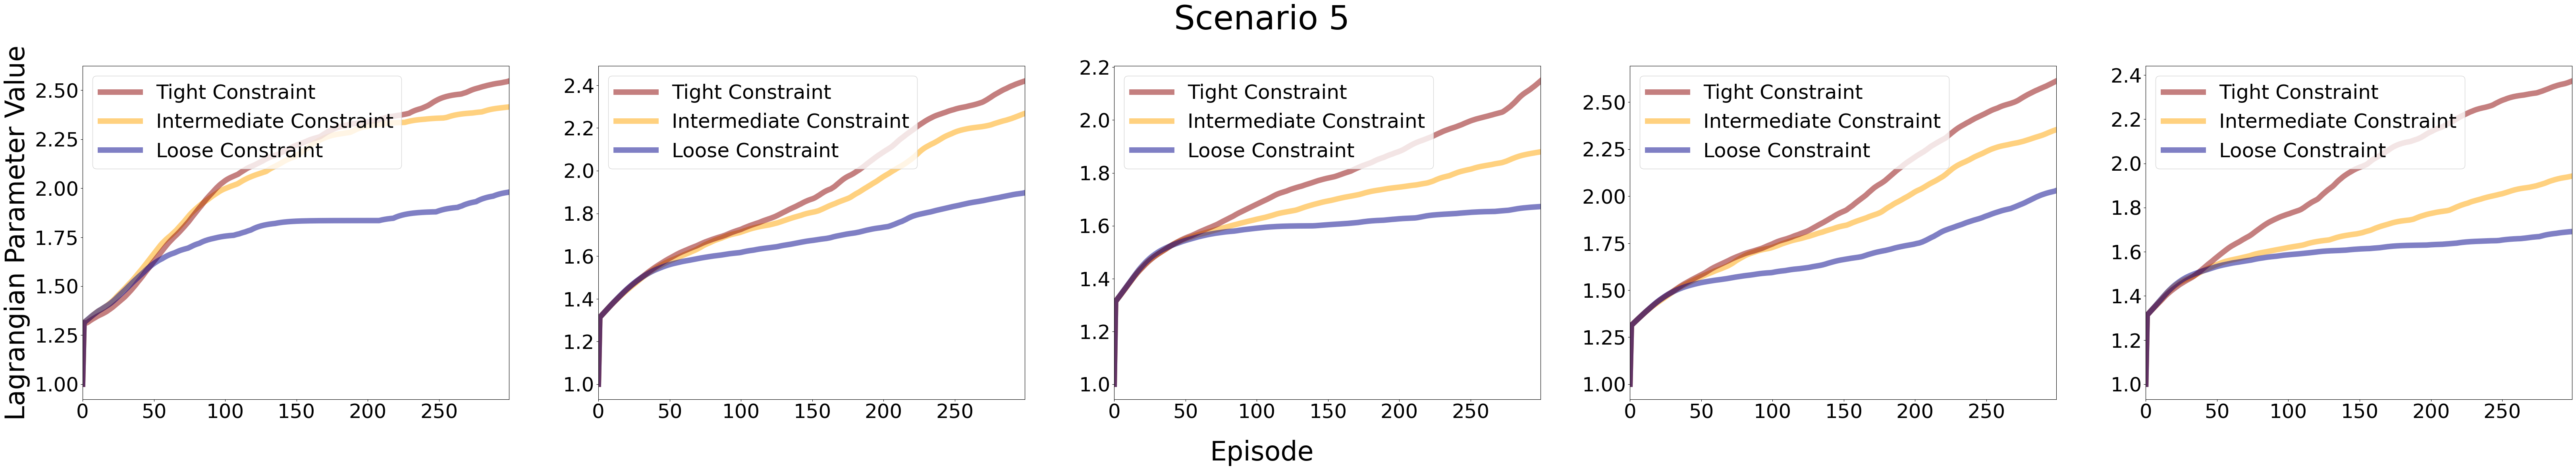

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

scenario_id = 5
file_names = [f'./lagrangian_parameter/scenario{scenario_id}-lagrangian-parameter-agent-{i}.csv' for i in range(0, 5)]

cols_to_plot = [1,4,7]

fig, axs = plt.subplots(1, 5, figsize=(66, 12), sharex=True, sharey=False)


for i, file_name in enumerate(file_names):
    df = pd.read_csv(file_name)

    data = df.iloc[:, cols_to_plot]
    last_values = data.iloc[-1, :]
    max_col_index = last_values.idxmax()
    min_col_index = last_values.idxmin()
    handles = []
    for j, col in enumerate(data.columns):

        if col == max_col_index:
            color = 'darkred'
            label = 'Weak Constraint'
        elif col == min_col_index:
            color = 'darkblue'
            label = 'Strong Constraint'
        else:
            color = 'orange'
            label = 'Intermediate Constraint'
        
        handle, = axs[i].plot(data.index, data[col], color=color, label=label, linewidth=10, alpha=0.5)
        handles.append((handle, label, color))
    
    handles_sorted = sorted(handles, key=lambda x: ['darkred', 'orange', 'darkblue'].index(x[2]))
    handles_sorted = [(h[0], h[1]) for h in handles_sorted]
    axs[i].legend(*zip(*handles_sorted), fontsize=36, loc='upper left')
for ax in axs:
    ax.tick_params(axis='both', labelsize=36)
fig.suptitle(f'Scenario {scenario_id}', fontsize=60)
fig.supxlabel('Episode', fontsize=48)
fig.supylabel('Lagrangian Parameter Value', fontsize=48)
plt.subplots_adjust(left=0.05,right=1,top=0.85,bottom=0.15,
                    wspace=0.21,hspace=0)
plt.xlim(0, 299)
plt.xticks(np.arange(0, 300, step=50))
plt.savefig(f"./lagrangian_parameter/scenario{scenario_id}_lagrangian_parameter.png")
plt.show()
